<a href="https://colab.research.google.com/github/1kaiser/test2023/blob/main/TestingSlicingImagesSAHI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import tensorflow as tf
import pathlib
dir='/content/files'
urls = 'https://github.com/1kaiser/Snow-cover-area-estimation/releases/download/v1/imagesfolder.zip'
data_dir = tf.keras.utils.get_file(origin=urls,
                                   fname='s',
                                   cache_subdir= dir,
                                   archive_format='auto',
                                   untar=False,
                                   extract=True)
!rm -r {dir}/s
data_dir = pathlib.Path(data_dir)

1116364563/1116364563 [==============================] - 75s 0us/step


#head

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os.path
import re

from osgeo import gdal

def tif2array(input_file, calc_gain=True):

    dataset = gdal.Open(input_file, gdal.GA_ReadOnly)
    image_datatype = dataset.GetRasterBand(1).DataType
    image = np.zeros((dataset.RasterYSize, dataset.RasterXSize, dataset.RasterCount), dtype=float)
   
    # Loop over all bands in dataset
    for b in range(dataset.RasterCount):
        # Remember, GDAL index is on 1, but Python is on 0 -- so we add 1 for our GDAL calls
        band = dataset.GetRasterBand(b + 1)
        # Read in the band's data into the third dimension of our array
        image[:, :, b] = band.ReadAsArray()
    return image, dataset


In [13]:
image_dir = r'/content/files/'

#############################################################################
prefix = "sur_refl_"
end = ["b01", "b02", "b03", "b04", "b05", "b06", "b07", "day_of_year", "qc_500m", "raz", "state_500m", "szen", "vzen"]
DayOY = "_doy\[0-9]+_aid0001"
fileExt = r'.tif'
expression_b1 = prefix+end[0]
expression_b2 = prefix+end[1]
expression_b3 = prefix+end[2]
expression_b4 = prefix+end[3]
expression_b5 = prefix+end[4]
expression_b6 = prefix+end[5]
expression_b7 = prefix+end[6]


imgs_list_b1 = [f for f in os.listdir(image_dir) if f.__contains__(expression_b1)]

imgs_list_b1.sort(reverse=True)       

In [14]:
from google.colab import output
temp_dir = r'/content/'

def ybatchedimages(images_path, image_list, batch_idx):
  images = []
  path = os.path.join(images_path, image_list[batch_idx])
  pathb2 = path.replace(expression_b1, expression_b2)
  pathb4 = path.replace(expression_b1, expression_b4)
  pathb6 = path.replace(expression_b1, expression_b6)

  #creating file NDSI
  !gdal_calc.py \
    --overwrite \
    --type=Float32 \
    --NoDataValue=0 \
    -A {pathb4} \
    --A_band 1 \
    -B {pathb6} \
    --B_band 1 \
    -C {pathb2} \
    --C_band 1 \
    --outfile={temp_dir}"BothCheck_result_final.tif" \
    --calc="(((A.astype(float) - B)/(A.astype(float) + B))>=0.4)*(C.astype(float)/10000>0.11)"

  pathout = temp_dir+str('BothCheck_result_final.tif')
  images.append(tif2array(pathout, 0)[0])

  !rm -r {temp_dir}"BothCheck_result_final.tif"
  output.clear()
  return images


import jax.numpy as jnp
def xbatchedimages(images_path, image_list, batch_idx):
  images = []
  path = os.path.join(images_path, image_list[batch_idx])
  v1 = tif2array(path.replace(expression_b1, expression_b1),0)[0]
  v2 = jnp.append(v1, tif2array(path.replace(expression_b1, expression_b2),0)[0] , axis =2)
  v3 = jnp.append(v2, tif2array(path.replace(expression_b1, expression_b3),0)[0] , axis =2)
  v4 = jnp.append(v3, tif2array(path.replace(expression_b1, expression_b4),0)[0] , axis =2)
  v5 = jnp.append(v4, tif2array(path.replace(expression_b1, expression_b5),0)[0] , axis =2)
  v6 = jnp.append(v5, tif2array(path.replace(expression_b1, expression_b6),0)[0] , axis =2)
  v7 = jnp.append(v6, tif2array(path.replace(expression_b1, expression_b7),0)[0] , axis =2)
  images.append(v7)
  w1 = tif2array(path.replace(expression_b1, expression_b1),0)[0]
  w2 = tif2array(path.replace(expression_b1, expression_b2),0)[0]
  w3 = tif2array(path.replace(expression_b1, expression_b3),0)[0]
  w4 = tif2array(path.replace(expression_b1, expression_b4),0)[0]
  w5 = tif2array(path.replace(expression_b1, expression_b5),0)[0]
  w6 = tif2array(path.replace(expression_b1, expression_b6),0)[0]
  w7 = tif2array(path.replace(expression_b1, expression_b7),0)[0]
  return images

import jax.random as random
import jax.numpy as jnp
batch_size = 1
no_of_batches = int(len(imgs_list_b1)/batch_size)
def data_stream(i, no_of_batches):
  return jnp.asarray(xbatchedimages(image_dir, imgs_list_b1, i)), jnp.asarray(ybatchedimages(image_dir, imgs_list_b1, i))

In [15]:

def get_slice_bboxes( image_height: int, image_width: int, slice_height: int = 224 , slice_width: int = 224, overlap_height_ratio: float = 0.0, overlap_width_ratio: float = 0.0 ):
  # """Slices `image_pil` in crops.
  # Corner values of each slice will be generated using the `slice_height`,
  # `slice_width`, `overlap_height_ratio` and `overlap_width_ratio` arguments.
  # Args:
  #     image_height (int): Height of the original image.
  #     image_width (int): Width of the original image.
  #     slice_height (int): Height of each slice. Default 512.
  #     slice_width (int): Width of each slice. Default 512.
  #     overlap_height_ratio(float): Fractional overlap in height of each
  #         slice (e.g. an overlap of 0.2 for a slice of size 100 yields an
  #         overlap of 20 pixels). Default 0.2.
  #     overlap_width_ratio(float): Fractional overlap in width of each
  #         slice (e.g. an overlap of 0.2 for a slice of size 100 yields an
  #         overlap of 20 pixels). Default 0.2.
  #     auto_slice_resolution (bool): if not set slice parameters such as slice_height and slice_width,
  #         it enables automatically calculate these params from image resolution and orientation.
  # Returns:
  #     List[List[int]]: List of 4 corner coordinates for each N slices.
  #         [
  #             [slice_0_left, slice_0_top, slice_0_right, slice_0_bottom],
  #             ...
  #             [slice_N_left, slice_N_top, slice_N_right, slice_N_bottom]
  #         ]
  # """
  slice_bboxes = []
  y_max = y_min = 0

  if slice_height and slice_width:
      y_overlap = int(overlap_height_ratio * slice_height)
      x_overlap = int(overlap_width_ratio * slice_width)
  else:
      raise ValueError("Compute type is not auto and slice width and height are not provided.")

  while y_max < image_height:
      x_min = x_max = 0
      y_max = y_min + slice_height
      while x_max < image_width:
          x_max = x_min + slice_width
          if y_max > image_height or x_max > image_width:
              xmax = min(image_width, x_max)
              ymax = min(image_height, y_max)
              xmin = max(0, xmax - slice_width)
              ymin = max(0, ymax - slice_height)
              slice_bboxes.append([xmin, ymin, xmax, ymax])
          else:
              slice_bboxes.append([x_min, y_min, x_max, y_max])
          x_min = x_max - x_overlap
      y_min = y_max - y_overlap
  return slice_bboxes




In [16]:
slices = get_slice_bboxes(233, 454)
for slice in slices:
  print(slice)
  

[0, 0, 224, 224]
[224, 0, 448, 224]
[230, 0, 454, 224]
[0, 9, 224, 233]
[224, 9, 448, 233]
[230, 9, 454, 233]


In [10]:
import numpy as np
a = np.zeros((1, 10, 10, 2))
b = np.ones((3, 3))
print(a.shape, b.shape)
a[0][ 10:13, 10:13, :] = b
a

(1, 10, 10, 2) (3, 3)


ValueError: ignored

In [17]:
b = data_stream(110, no_of_batches)
# print(b)

def slicedImageInput(i, b):
    b1 = b[0]
    b1.swapaxes(1,3).swapaxes(2,3)
    ######################<< xinput images sliced
    ximages = []
    for j in range(b1.shape[3]):
      if (j==0):
        a = b1[:, i[1]:i[3], i[0]:i[2], j]
      else:
        a = np.append(a, b1[:, i[1]:i[3], i[0]:i[2], j], axis = 0)
    ximages = np.expand_dims(a, axis = 0)
    ximages = ximages.swapaxes(1,2).swapaxes(2,3)

    b2 = b[1]
    b2.swapaxes(1,3).swapaxes(2,3)
    ######################<< yinput images sliced
    yimages = []
    for j in range(b2.shape[3]):
      if (j==0):
        a = b2[:, i[1]:i[3], i[0]:i[2], j]
      else:
        a = np.append(a, b2[:, i[1]:i[3], i[0]:i[2], j], axis = 0)
    yimages = np.expand_dims(a, axis = 0)
    yimages = yimages.swapaxes(1,2).swapaxes(2,3)
    print(jnp.asarray(ximages).shape, jnp.asarray(yimages).shape)
    return jnp.asarray(ximages), jnp.asarray(yimages)

for i in get_slice_bboxes(b[0].shape[1], b[0].shape[2]):
  print(i, "<< th slice")
  slicedImageInput(i, b)

# slicedImageInput(get_slice_bboxes(b[0].shape[1], b[0].shape[2])[0], b)

[0, 0, 224, 224] << th slice
(1, 224, 224, 7) (1, 224, 224, 1)
[224, 0, 448, 224] << th slice
(1, 224, 224, 7) (1, 224, 224, 1)
[230, 0, 454, 224] << th slice
(1, 224, 224, 7) (1, 224, 224, 1)
[0, 9, 224, 233] << th slice
(1, 224, 224, 7) (1, 224, 224, 1)
[224, 9, 448, 233] << th slice
(1, 224, 224, 7) (1, 224, 224, 1)
[230, 9, 454, 233] << th slice
(1, 224, 224, 7) (1, 224, 224, 1)


# **Final TEST**

In [18]:
positional_encoding_dims = 6  # Number of positional encodings applied
import matplotlib.pyplot as plt

def positional_encoding(args):
    image_height_x_image_width, cha = args.shape
    print(args.shape)
    inputs_freq = jax.vmap(lambda x: args * 2.0 ** x)(jnp.arange(positional_encoding_dims))
    a = plotter(inputs_freq)
    a = np.array(a*100,  dtype=np.uint8)

    x = jnp.stack([jnp.sin(inputs_freq), jnp.cos(inputs_freq)])
    b1, b2 = x[0], x[1]
    b1 = plotter(b1)
    b1 = np.array(b1*100,  dtype=np.uint8)
    b2 = plotter(b2)
    b2 = np.array(b2*100,  dtype=np.uint8)

    x = x.swapaxes(0, 2).reshape([image_height_x_image_width, -1])
    x = jnp.concatenate([args, x], axis=-1)
    c1 = SquareArray(x)


    plt.axis('off')
    f, axarr = plt.subplots(4, sharex=True, figsize=(20, 20))
    plt.tight_layout() 
    axarr[0].axis('off')
    axarr[0].imshow(a, cmap = 'magma' )
    axarr[1].axis('off')
    axarr[1].imshow(b1)
    axarr[2].axis('off')
    axarr[2].imshow(b2)
    axarr[3].axis('off')
    axarr[3].imshow(c1, cmap = 'terrain')

    plt.tight_layout() 
    plt.axis('off')
    plt.show()

    return x


In [19]:
import matplotlib.pyplot as plt
import numpy as np


####################
batches = data_stream(1, no_of_batches)
batches = slicedImageInput(get_slice_bboxes(batches[0].shape[1], batches[0].shape[2])[0], batches)
newsize = (batches[0].shape[1], batches[0].shape[2])
################3###
def plotter(a):
  channels = a.shape[2]
  a1 = []
  for i in range(a.shape[0]):
    xxx = cv2.split(np.array(a[i].reshape((newsize[0], newsize[1], channels))))
    # print(xxx[i].shape)
    for j in range(len(xxx)):
      if (j==0):
        a1 = xxx[j]
      else:
        a1 = np.append(a1, xxx[j], 0)

    if (i==0):
      b1 = a1
    else:
      b1 = np.append(b1, a1, 1)
  return b1


def SquareArray(input):
  limit = int(np.sqrt(input.shape[1]))+1
  input = jnp.concatenate([input,jnp.zeros((input.shape[0], limit*limit-input.shape[1]))], axis=-1)
  input = input.reshape((newsize[0], newsize[1], input.shape[1]))
  
  for i in range(int(limit)):
    for j in range(int(limit)):

      if (j==0):
        a1 = input[:,:,i]
      else:
        a1 = np.append(a1, input[:, :, i], 1)

    if (i==0):
      b1 = a1
    else:
      b1 = np.append(b1, a1, 0)
  return b1

(1, 224, 224, 7) (1, 224, 224, 1)


In [20]:
#✅
import jax
import jax.numpy as jnp

import cv2
from google.colab.patches import cv2_imshow
import numpy as np 


def batch_encoded(args):
    img_list = []
    for i in range(args.shape[0]):
        c = args[i]
        c = c.reshape(-1, c.shape[2])
        p = positional_encoding(c)
        img_list.append(p.reshape(args.shape[1], args.shape[2], p.shape[1]))
        x = jnp.array(img_list)
    return x

#✅
!python -m pip install -qq -U flax orbax
# Orbax needs to enable asyncio in a Colab environment.
!python -m pip install -qq nest_asyncio


import jax
import jax.numpy as jnp

import flax
import optax
from typing import Any

from jax import lax
import flax.linen as nn
from flax.training import train_state, common_utils

apply_positional_encoding = True # Apply posittional encoding to the input or not
ndl = 8 # num_dense_layers Number of dense layers in MLP
dlw = 256 # dense_layer_width Dimentionality of dense layers' output space 

##########################################<< MLP MODEL >>#########################################
class MLPModel(nn.Module):
    dtype: Any = jnp.float32
    precision: Any = lax.Precision.DEFAULT
    apply_positional_encoding: bool = apply_positional_encoding
    @nn.compact
    def __call__(self, input_points):
      x = batch_encoded(input_points) if self.apply_positional_encoding else input_points
      for i in range(ndl):
          x = nn.Dense(dlw,dtype=self.dtype,precision=self.precision)(x)
          x = nn.relu(x)
          x = jnp.concatenate([x, input_points], axis=-1) if i == 4 else x
      x = nn.Dense(1, dtype=self.dtype, precision=self.precision)(x)
      return x
##########################################<< MLP MODEL >>#########################################

#✅
!python -m pip install -q -U flax
import optax
from flax.training import train_state
import jax.numpy as jnp
import jax


def Create_train_state(r_key, model, shape, learning_rate ) -> train_state.TrainState:
    variables = model.init(r_key, jnp.ones(shape)) 
    optimizer = optax.adam(learning_rate) 
    return train_state.TrainState.create(
        apply_fn = model.apply,
        tx=optimizer,
        params=variables['params']
    )

learning_rate = 1e-4
model = MLPModel() # Instantiate the Model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.4/197.4 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 KB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 KB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 KB 13.2 MB/s eta 0:00:00


In [41]:
#cpu serial
import jax

def train_step(state: train_state.TrainState, batch: jnp.asarray, rng):
    image, label = batch  
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, image);
        loss =  image_difference_loss(logits, label);
        return loss, logits

    gradient_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (_, logits), grads = gradient_fn(state.params)
    new_state = state.apply_gradients(grads=grads)
    logs = compute_metrics(logits=logits, labels=label)
    return new_state, logs

import jax
@jax.jit
def eval_step(state, image):
    logits = state.apply_fn({'params': state.params}, image)
    return compute_metrics(logits=logits, labels=image)


#serial
def image_difference_loss(logits, labels):
    loss =  0.5 * jnp.mean((logits - labels) ** 2) 
    return loss
    
def compute_metrics(*, logits, labels):
  loss = image_difference_loss(logits, labels)
  metrics = {
      'loss': loss,     #LOSS
      'logits': logits, #PREDICTED IMAGE
      'labels': labels  #ACTUAL IMAGE
  }
  return metrics

import cv2
from google.colab.patches import cv2_imshow
import numpy as np 

def show_image(pimage, oimage, newsize):
  L1 = pimage[0]
  predicted_image = np.array(pimage*255,  dtype=np.uint8).reshape(newsize) # This would be your image array
  original_image = np.array(oimage*255,  dtype=np.uint8).reshape(newsize) # This would be your image array
  a = cv2.vconcat([predicted_image, original_image])

  # for i in range(0,pimage.shape[0]):
  #   predicted_image = np.array(pimage[i]*255,  dtype=np.uint8).reshape(newsize)
  #   original_image = np.array(oimage[i]*255,  dtype=np.uint8).reshape(newsize) # This would be your image array
 
  #   a = cv2.hconcat([a, cv2.vconcat([predicted_image, original_image]))
  cv2_imshow(a)

[0, 0, 224, 224] << th slice
(1, 224, 224, 7) (1, 224, 224, 1)
(50176, 7)


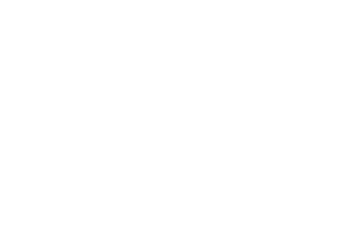

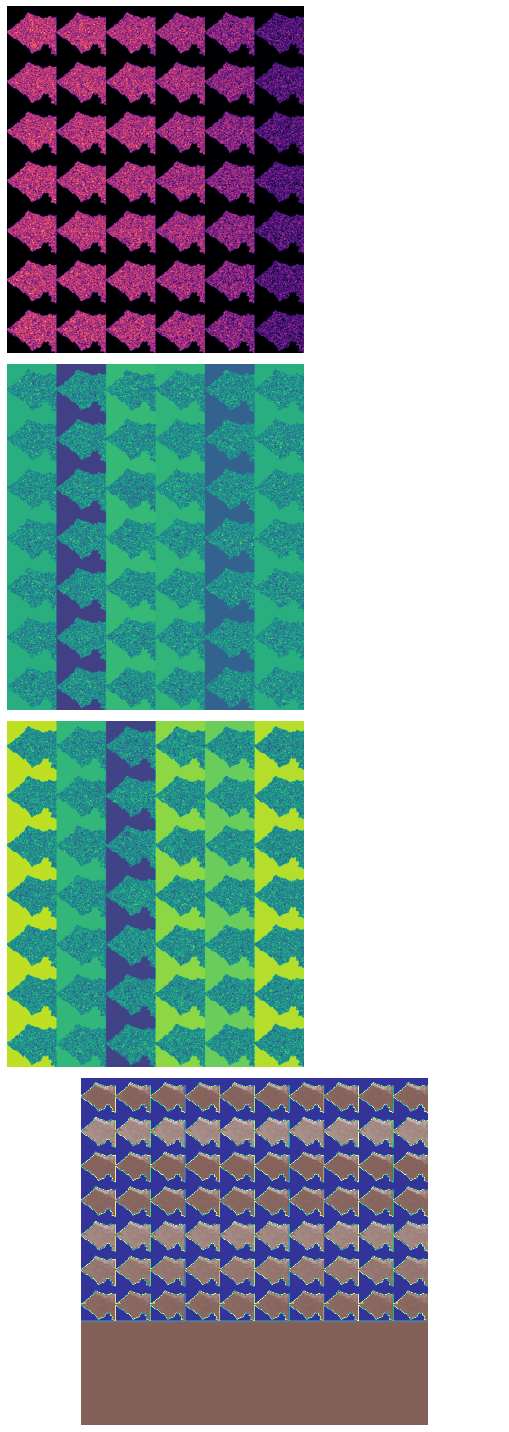

loss:  763.1524  <<< 


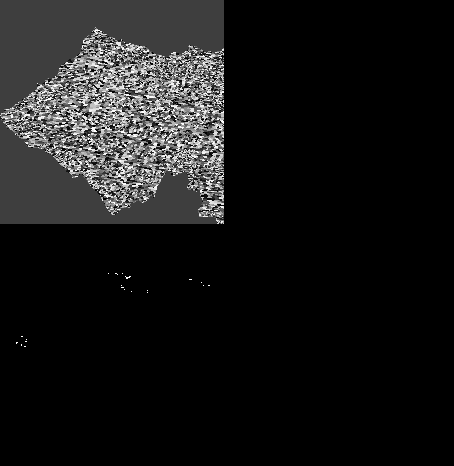

[224, 0, 448, 224] << th slice
(1, 224, 224, 7) (1, 224, 224, 1)
(50176, 7)


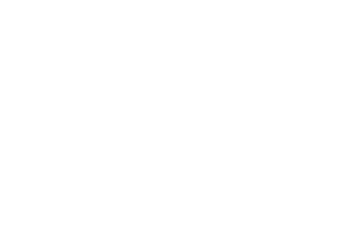

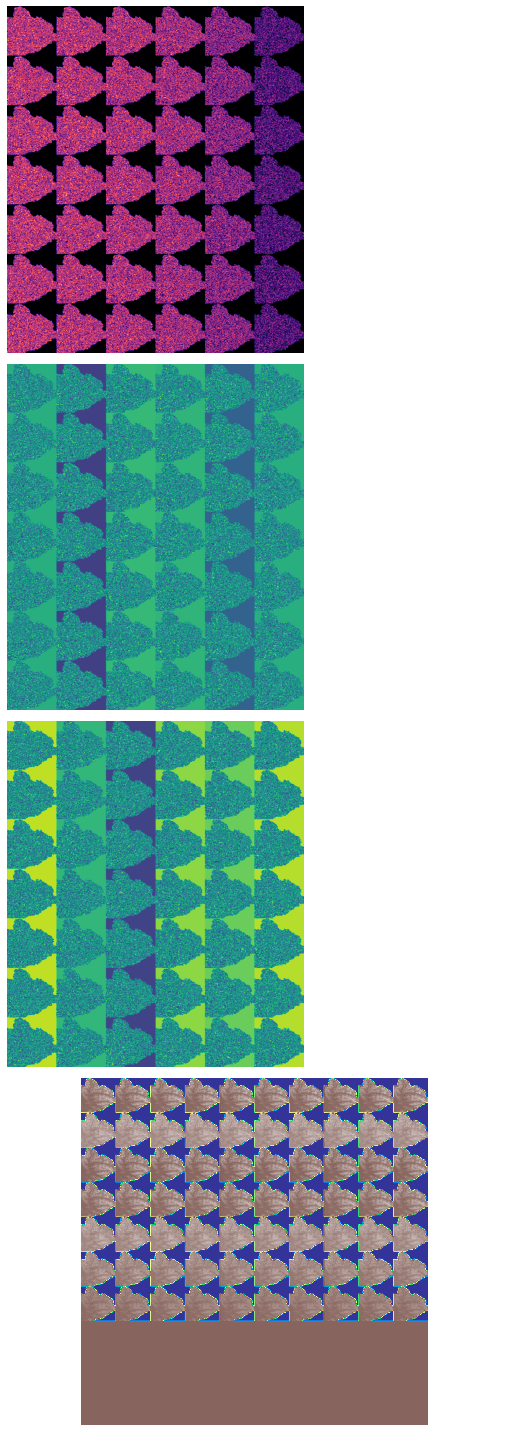

loss:  1518.6715  <<< 


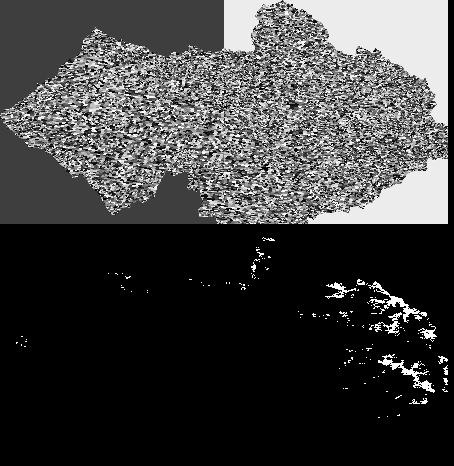

[230, 0, 454, 224] << th slice
(1, 224, 224, 7) (1, 224, 224, 1)
(50176, 7)


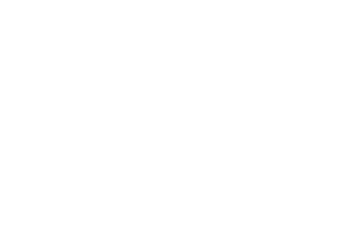

  0%|          | 0/150 [01:34<?, ?it/s]


KeyboardInterrupt: ignored

In [43]:
#@title # **👠HIGH HEELS RUN >>>>>>>>>>>** { vertical-output: true }
# newsize = (233, 454) #(260, 260) # /.... 233 * 454

import jax
from jax import random
from tqdm import tqdm
import re
from google.colab import output
import orbax.checkpoint as orbax
from flax.training import checkpoints

import optax
import nest_asyncio
nest_asyncio.apply()

rng = jax.random.PRNGKey(0)
CKPT_DIR = 'ckpts'

######################<<<< initiating train state
batches = data_stream(1, no_of_batches)
batches = slicedImageInput(get_slice_bboxes(batches[0].shape[1], batches[0].shape[2])[0], batches)
newsize = (batches[0].shape[1], batches[0].shape[2])
count = 0
if count == 0 :
  BATCH, H, W, Channels = batches[0].shape
  state = Create_train_state( rng, model, (BATCH, H, W, Channels ), learning_rate ) 
  count = 1
#✅✅🔻 state = flax.jax_utils.replicate(state)  # FLAX will replicate the state to every device so that updating can be made easy

###################### 
checkpoint_available = 0
pattern = re.compile("checkpoint_\d+")   # to search for "checkpoint_*munerical value*" numerical value of any length is denoted by regular expression "\d+"
dir = "/content/ckpts/"
isFile = os.path.isdir(dir)
if isFile:
  for filepath in os.listdir(dir):
      if pattern.match(filepath):
          checkpoint_available = 1

total_epochs = 150
for epochs in tqdm(range(total_epochs)):  

  if checkpoint_available:
    state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=state)
    checkpoint_available = 0 # << Flag updated >>> to stop loading the same checkpoint in the next iteration then remove the checkpoint directory
    !rm -r {dir}


  for Aimage in tqdm(range(no_of_batches-5)):
    input_data = data_stream(Aimage, no_of_batches)

    main_size = (input_data[0].shape[1], input_data[0].shape[2])
    xoutput = np.zeros(main_size)
    youtput = np.zeros(main_size)
    for i in get_slice_bboxes(main_size[0], main_size[1]):
      print(i, "<< th slice")
      input_x_y_images = slicedImageInput(i, input_data)
      state, metrics = train_step(state, input_x_y_images, rng)
      xoutput[i[1]:i[3], i[0]:i[2]] = np.array(metrics['logits'].swapaxes(1, 3).swapaxes(2, 3)[0][0])
      youtput[i[1]:i[3], i[0]:i[2]] = np.array(metrics['labels'].swapaxes(1, 3).swapaxes(2, 3)[0][0])

      print("loss: ", metrics['loss']," <<< ") # naming of the checkpoint is "checkpoint_*"  where "*" => value of the steps variable, i.e. 'epochs'
      show_image(xoutput, youtput, main_size)

  orbax_checkpointer = orbax.Checkpointer(orbax.PyTreeCheckpointHandler())
  checkpoints.save_checkpoint(ckpt_dir=CKPT_DIR, target=state, step=epochs, prefix='checkpoint_', keep=1, overwrite=False, orbax_checkpointer=orbax_checkpointer)
  # restored_state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=state) # using to get the checkpoint loaded , it can be latest one , or if already available as checkpoint in the "CKPT_DIR" directory then take the file from directory then save in >> restored_checkpoints
  ##################################################

